In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import dblquad
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

from dataloader import FastTensorDataLoader

# Poisson Point Processes

## Data Generation

In [2]:
def generate_poisson_points(kappa, scale, region):
    """
    Generate a Poisson Point Process in a 2D region based on intensity function.
    
    Parameters:
    - kappa (torch.Tensor): The intensity parameter (scalar or vector).
    - scale (torch.Tensor): The scale parameter (scalar or vector).
    - region (tuple): The spatial domain as ((xmin, xmax), (ymin, ymax)).
    - num_samples (int): Number of candidate points to sample for rejection sampling.
    
    Returns:
    - points (numpy.ndarray): The simulated points of the PPP.
    """
    (xmin, xmax), (ymin, ymax) = region

    area = (xmax - xmin) * (ymax - ymin)
    max_intensity = kappa * area  # Maximum value of intensity
    num_samples = np.random.poisson(lam=max_intensity)[0]

    x_candidates = np.random.uniform(xmin, xmax, size=num_samples)
    y_candidates = np.random.uniform(ymin, ymax, size=num_samples)
    candidates = torch.tensor(np.stack([x_candidates, y_candidates], axis=1), dtype=torch.float32)
    
    squared_norm = torch.sum(candidates**2, dim=-1)
    intensity = kappa * torch.exp(-squared_norm / scale**2)
    
    uniform_samples = torch.rand(num_samples)  # Uniform samples for rejection
    acceptance_mask = uniform_samples < (intensity / kappa)
    
    accepted_points = candidates[acceptance_mask]
    return accepted_points.numpy()

In [26]:
kappa = torch.tensor([100.0])
scale = torch.tensor([0.5])

region = ((0, 1), (0, 1))  # A square domain in 2D

In [27]:
num_samples = 10000
samples = []
x_test = None
for _ in range(num_samples):
    x_t = generate_poisson_points(kappa, scale, region)
    if x_test is None:
        x_test = x_t.copy()
    samples.append(torch.tensor(x_t))

In [28]:
X = pad_sequence(samples, batch_first=True, padding_value=0)
lengths = torch.tensor([len(s) for s in samples], dtype=torch.int64)

lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)

X_train = X[:100]
X_val = X[100:150]
loader_train = FastTensorDataLoader(X_train, batch_size=1000, shuffle=False)
loader_val = FastTensorDataLoader(X_val, batch_size=1000, shuffle=False)

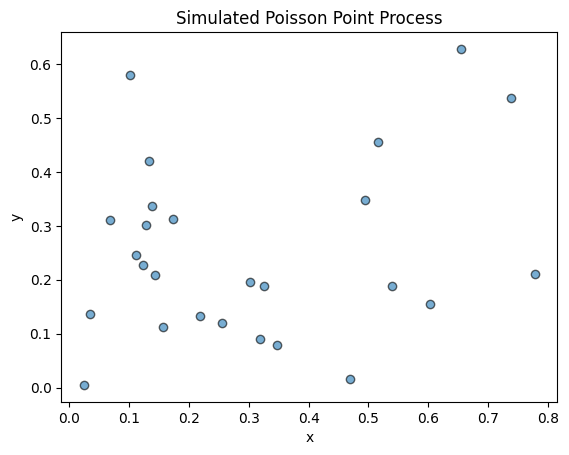

In [29]:
plt.scatter(x_test[:, 0], x_test[:, 1], alpha=0.6, edgecolor='k')
plt.title("Simulated Poisson Point Process")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Optimization function

In [30]:
def optimize_theta(loader_train, nn_model, num_epochs=1000, learning_rate=1e-3):
    """
    Optimizes the model parameters.

    Args:
        loader_train (DataLoader): DataLoader for training data.
        nn_model (callable): Function that creates the neural network model.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate.

    Returns:
        tuple: (trained model, losses)
    """
    model = nn_model()
    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(num_epochs):
        for X_batch in loader_train:
            optimizer.zero_grad()

            loss = model.loss(X_batch[0])

            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses


## Poisson Model

In [33]:
class Poisson(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor([torch.abs(torch.randn(1))], dtype=torch.float32))

    def forward(self, x):
        squared_norm = torch.sum(x**2, dim=-1)
        return - squared_norm / self.scale**2

    def compute_psi(self, x):
        x.requires_grad_()
        nn_output = self.forward(x)
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi

    def loss(self, points):
        lengths = points[:, 0, -1].to(dtype=torch.int64)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]  # Pad to max length in batch
 
        psi_x = self.compute_psi(x_t)
        norm_squared = (psi_x ** 2).sum(dim=-1)  # Sum across all dimensions

        # padded values give none zero divergence -> mask 
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        divergence = 0
        for i in range(x_t.shape[-1]):  # Iterate over the features of x
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]  # Sum over each feature dimension
        
        divergence = divergence * mask
        total_loss = 0.5 * norm_squared + divergence
        total_loss = total_loss.sum(dim=-1)/lengths  # Sum over the time dimension
        
        return total_loss.mean()

### Batch processing

In [39]:
start_time = time.time()
epochs = 100
model, losses = optimize_theta(
    loader_train, Poisson, num_epochs=epochs, learning_rate=1e-2,
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Execution Time: {elapsed_time:.2f} seconds")

Epoch 0/100, Loss: -6.887706756591797
Epoch 1/100, Loss: -7.333472728729248
Epoch 2/100, Loss: -7.738385200500488
Epoch 3/100, Loss: -8.073716163635254
Epoch 4/100, Loss: -8.308950424194336
Epoch 5/100, Loss: -8.414998054504395
Epoch 6/100, Loss: -8.368256568908691
Epoch 7/100, Loss: -8.368256568908691
Epoch 8/100, Loss: -8.410776138305664
Epoch 9/100, Loss: -8.410412788391113
Epoch 10/100, Loss: -8.410412788391113
Epoch 11/100, Loss: -8.41849136352539
Epoch 12/100, Loss: -8.41849136352539
Epoch 13/100, Loss: -8.41656494140625
Epoch 14/100, Loss: -8.41656494140625
Epoch 15/100, Loss: -8.418038368225098
Epoch 16/100, Loss: -8.418463706970215
Epoch 17/100, Loss: -8.418463706970215
Epoch 18/100, Loss: -8.41843032836914
Epoch 19/100, Loss: -8.41843032836914
Epoch 20/100, Loss: -8.41849136352539
Epoch 21/100, Loss: -8.41844654083252
Epoch 22/100, Loss: -8.41844654083252
Epoch 23/100, Loss: -8.418484687805176
Epoch 24/100, Loss: -8.418488502502441
Epoch 25/100, Loss: -8.418488502502441
Epoch

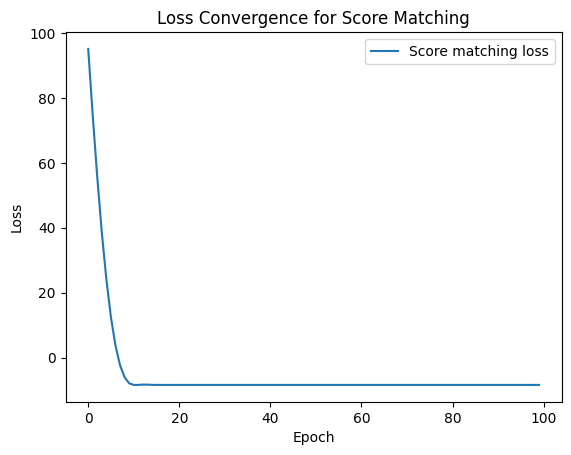

In [35]:
plt.plot(losses, label="Score matching loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.legend()
plt.show()


In [36]:
print("Estimated scale:", model.scale)
print("True scale:", scale)

Estimated scale: Parameter containing:
tensor([0.4874], requires_grad=True)
True scale: tensor([0.5000])


### Kappa Inference

In [37]:
def infer_kappa(x_t, sigma, region):
    """
    Infers the parameter kappa for the Poisson Point Process intensity function
    given the data x_t and the known scale parameter sigma.
    
    Args:
    - x_t: numpy array of shape (n, d), where n is the number of data points and d is the dimension of the data.
    - sigma: the known scale parameter (positive real number).
    
    Returns:
    - kappa: the inferred scaling factor for the intensity function.
    """
    (a1, b1), (a2, b2) = region
    n = len(x_t)
    
    def integrand(x0, x1, sigma):
        return np.exp(-(x0**2 + x1**2) / sigma**2)

    integral_result, _ = dblquad(integrand, a1, b1, lambda x0: a2, lambda x0: b2, args=(sigma,))
    
    kappa = n / integral_result
    return kappa

In [38]:
kappa = infer_kappa(x_t, model.scale.detach().numpy(), region)
print(f"Inferred kappa: {kappa}")

Inferred kappa: 134.9848623088812


## Neural Network Poisson Model


In [ ]:
class Poisson_NN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10, output_dim=1):
        super().__init__()
        self.intensity = nn.Parameter(torch.tensor([np.abs(np.random.randn())], dtype=torch.float32))
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        intensity = self.fc2(x)
        return torch.exp(intensity)
    
    def compute_psi(self, x):
        x.requires_grad_()
        nn_output = self.forward(x)
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi

    def loss(self, points):
        lengths = points[:, 0, -1].to(dtype=torch.int64)
        x_t = points[:, :lengths.max(), :-1]  # Pad to max length in batch
 
        psi_x = self.compute_psi(x_t)
        norm_squared = (psi_x ** 2).sum(dim=-1)  # Sum across all dimensions

        divergence = 0
        for i in range(x_t.shape[-1]):  # Iterate over the features of x
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]  # Sum over each feature dimension
        
        total_loss = 0.5 * norm_squared + divergence
        total_loss = total_loss.sum(dim=-1)  # Sum over the time dimension
        
        return total_loss.mean()

In [100]:
start_time = time.time()
epochs = 100
model, losses = optimize_theta(
    loader_train, Poisson_NN, num_epochs=epochs, learning_rate=1e-3,
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Execution Time: {elapsed_time:.2f} seconds")

Epoch 0/100, Loss: 9.800891876220703
Epoch 1/100, Loss: 9.572905540466309
Epoch 2/100, Loss: 9.304296493530273
Epoch 3/100, Loss: 8.989048957824707
Epoch 4/100, Loss: 8.620810508728027
Epoch 5/100, Loss: 8.193161964416504
Epoch 6/100, Loss: 7.700069427490234
Epoch 7/100, Loss: 7.136363983154297
Epoch 8/100, Loss: 6.498868465423584
Epoch 9/100, Loss: 5.788050651550293
Epoch 10/100, Loss: 5.009031772613525
Epoch 11/100, Loss: 4.174185276031494
Epoch 12/100, Loss: 3.3063852787017822
Epoch 13/100, Loss: 2.4343416690826416
Epoch 14/100, Loss: 1.584862232208252
Epoch 15/100, Loss: 0.7720220685005188
Epoch 16/100, Loss: -0.04365512356162071
Epoch 17/100, Loss: -0.8946564197540283
Epoch 18/100, Loss: -1.8421684503555298
Epoch 19/100, Loss: -2.999910831451416
Epoch 20/100, Loss: -4.4993486404418945
Epoch 21/100, Loss: -6.628369331359863
Epoch 22/100, Loss: -9.830718040466309
Epoch 23/100, Loss: -14.768641471862793
Epoch 24/100, Loss: -23.161592483520508
Epoch 25/100, Loss: -39.1743278503418
Epo

In [86]:
def compute_intensity(points, kappa, scale):
    squared_norm = torch.sum(points**2, dim=-1)
    intensity = kappa * torch.exp(-squared_norm / scale**2)
    return intensity

In [87]:
def calculate_mean_intensity(samples, kappa, scale):
    total_intensity = 0
    total_points = 0
    
    for sample in samples:
        # Compute intensity for each point in the sample
        intensities = compute_intensity(sample, kappa, scale)
        total_intensity += intensities.sum()
        total_points += len(sample)
    
    # Average intensity per sample
    mean_intensity = total_intensity / total_points
    return mean_intensity

In [98]:
intensity = calculate_mean_intensity(samples, kappa, scale)

In [101]:
print("Estimated intensity:", model.intensity)
print("True intensity:", intensity)

Estimated intensity: Parameter containing:
tensor([0.0528], requires_grad=True)
True intensity: tensor(504.7337)
